## Business Goals:
* Use Stack Overflow question posts to predict language tags
  * Choose top 5 most common langauge tags:
    - Java, C#, JavaScript, Python, C++ 
  * Better target and recommend similar question answers to improve website interaction 
-----

### Data info:  
  * 30,000 raw posts from Stack Overflow
  * data types: string 
----

### Special python packages:

  * NLTK - text preprocessing 
  * Sklearn - machine learning 
  * Gensim - topic clustering 
  * Yellowbrick - evaluation visuals

#### Web App for predicting tags: 

  * [Check it out here](https://tag-predictor.netlify.com/)

### Text Preprocessing: 
  * see notebooks/Text_Preprocess.ipynb for details
  * main package: NLTK 
  * steps:  
      1) clean each text (only keep letters and lower case)  
      2) tokenize  
      3) find position tags to better lemmatize the words   
      4) remove stop words, remove words less than 3 letter length, and remove tags   
      5) join the tokens back into cleaned text and keep token column

### Load Necessary Libaries and .py files 

In [62]:
import gensim
from gensim import corpora, models
import warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils")

from construct_model import *
from text_pre_processor import *
from Helper_Function_MachineLearning_Clustering import *

%aimport construct_model
%aimport text_pre_processor
%aimport Helper_Function_MachineLearning_Clustering

## Load Cleaned DataFrame and Split into feature and target 

In [71]:
posts_df = pd.read_pickle('../data/interum/text_target.pkl')
# convert into features and target
feature = posts_df['cleaned_text']
label = posts_df['target']

### Visualize tag distribution

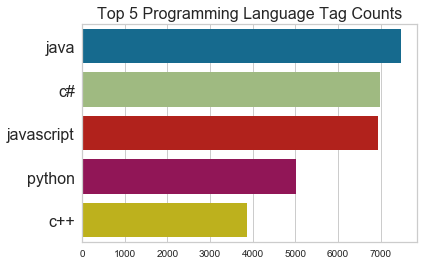

In [22]:
Tags = label.value_counts().index.tolist()
Count = label.value_counts().tolist()
sns.barplot(x=Count, y = Tags)
plt.title('Top 5 Programming Language Tag Counts', size = 16)
plt.yticks(size = 16)
plt.show()

------
### Chosen models after trying many classifiers:

  * metric: accuracy and confusion matrix

  * Models tried using default settings:
    * Adaboost
    * Xgboost
    * Random Forest 
    * Multinomial Naive Bayes
    * Logistic Regression
    * SVM classifier 
  * 3 chosen models: 
    * LogisticRegression

    * RandomForest

    * MultinomialNB
  * ensemble:
    * combine all 3 results and pick the majority option if not all different, use np.random.choice

------
    
#### Logistic Regression: 

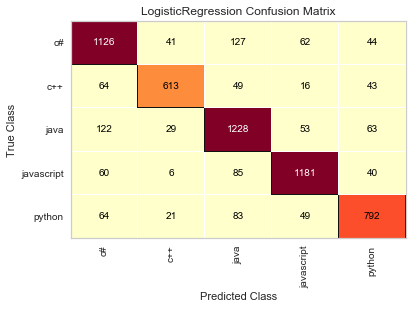

In [23]:
# after paramater tuning logistic regression works best with slight tuning for tfidvector
tfidf_vect_lg = TfidfVectorizer(ngram_range=(
    1, 2), max_df=0.5, min_df=6, max_features=9000)
# hyperparamater from extensive model gridsearch/randomsearch
lg = LogisticRegression(C=2, penalty='l1', random_state=42)
# run model and get results for logistic regression
lg_model = ConstructModel([tfidf_vect_lg, lg], feature, label)
# confusion matrix
lg_model.get_confusion_matrix()

#### Random Forest:

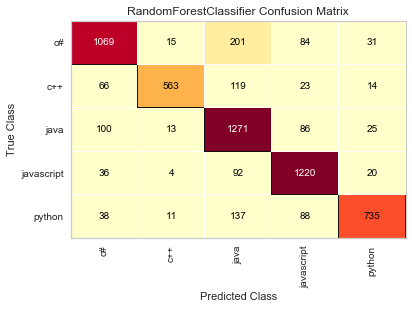

In [29]:
# after paramater tuning, a default settings works best
tfidf_vect_rf = TfidfVectorizer()
# hyperparamater from extensive model gridsearch/randomsearch
rf = RandomForestClassifier(
    criterion='gini', max_depth=1500, max_leaf_nodes=1000,
    min_samples_leaf=2, min_samples_split=2, n_estimators=1000, random_state=42)
# run model and get results for random forest
rf_model = ConstructModel([tfidf_vect_rf, rf], feature, label)
# check confusion matrix
rf_model.get_confusion_matrix()

#### Multinominal Naive Bayes

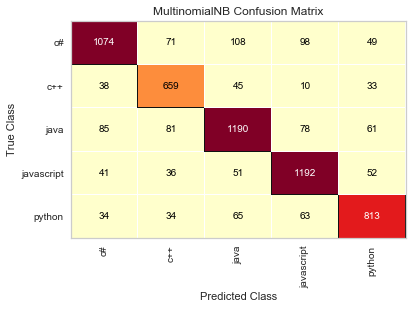

In [30]:
# after paramater tuning, a default settings works best
tfidf_vect_nb = TfidfVectorizer()
# hyperparamater from extensive model gridsearch/randomsearch
nb = MultinomialNB(alpha=0.1, fit_prior=False)
# run model and get results for nb
nb_model = ConstructModel([tfidf_vect_nb, nb], feature, label)
# check confusion matrix
nb_model.get_confusion_matrix()

#### ensemble method 

  - Based upon the confusion matrix results, certain models do a better job predict certain label 
  
  - Combine and get majority vote as final results 

In [36]:
# combine predictions from all three predicted results 
combined_pred = majority_vote(lg_pred, rf_pred, nb_pred)
# true test Y and class labels are the same for all models 
confusion_matrix_df(lg_model,lg_estimator,combined_pred)

,c# Pred,c++ Pred,java Pred,javascript Pred,python Pred
c# True,1122,35,133,74,36
c++ True,55,623,65,11,31
java True,79,25,1276,69,46
javascript True,39,9,73,1213,38
python True,40,14,90,62,803


### Final accuracy score among all 4 models

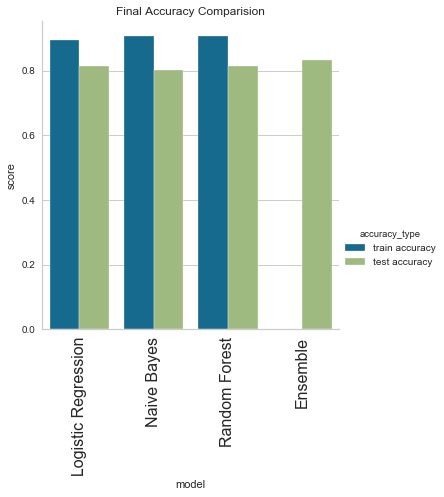

In [38]:
columns = ['Logistic Regression','Naive Bayes','Random Forest','Ensemble']
train_accuracy = [0.893,0.908,0.908,0]
test_accuracy = [0.815,0.802,0.813,0.831]
df_accuracy = pd.DataFrame([columns,train_accuracy,test_accuracy]).T
df_accuracy.columns = ['model','train accuracy','test accuracy']
df_accuracy = pd.melt(df_accuracy, id_vars='model',
                      var_name='accuracy_type', value_name='score')
sns.set_style("whitegrid")
sns.factorplot(x='model',y='score',hue='accuracy_type', data=df_accuracy, kind = 'bar')
plt.xticks(rotation = 90, size = 16)
plt.title('Final Accuracy Comparision')
plt.show()

### Extract feature information:
  * Top 10 keys words for all 3 models 

In [39]:
# check Helper_Function_MachineLearning_Clustering.py for details 
# extract coefs for logistic regression and naive bayes 
lg_coef_f = coef_features(lg_model.pipe)
nb_coef_f = coef_features(nb_model.pipe,lg=False)

### Logistic regression top 10 key tokens per tag

In [40]:
lg_f = top_10_feature(lg_coef_f)
lg_f

,c#_lg,c++_lg,java_lg,javascript_lg,python_lg
0,writeline,boost,jvm,jquery,django
1,net,cout,jdk,backbone,numpy
2,dispose,std,jsp,console log,py
3,resharper,qt,system println,angularjs,def
4,window form,cpp,println,prototype,pythonic
5,linq,stl,spring,ecmascript,pep
6,msdn,gcc,jar,alert,matplotlib
7,ienumerable,int main,junit,browser,urllib
8,xaml,header file,hibernate,jslint,sqlalchemy
9,wpf,std string,jdbc,angular,typeerror


### Naive Bayes top 10 key tokens per tag

In [41]:
nb_f = top_10_feature(nb_coef_f,lg=False)
nb_f

,c#_nb,c++_nb,java_nb,javascript_nb,python_nb
0,string,std,string,function,list
1,use,int,class,jquery,file
2,public,use,use,use,use
3,class,const,file,var,print
4,net,function,method,div,py
5,get,class,public,page,like
6,method,code,new,like,way
7,new,vector,get,html,self
8,code,foo,like,script,get
9,list,string,way,way,line


### Random Forest top 10 key tokens

Text(0.5, 1.0, 'Random Forest Top 10 most Important Key Word Features')

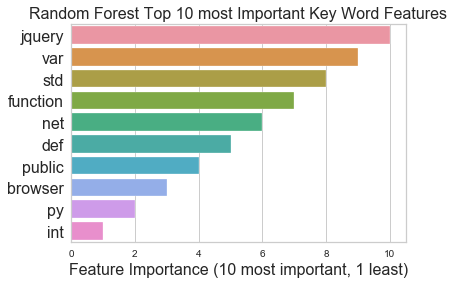

In [43]:
importance_score_rf = rf_estimator.feature_importances_
feature_name_rf = rf_model.pipe[0].get_feature_names()
importance_f_rf =[]
for c, f in zip(importance_score_rf,feature_name_rf):
    if c:
        importance_f_rf.append((f,c))
top_10 = sorted(importance_f_rf, key=lambda x: x[1], reverse = True)[:10]
sns.barplot(x= np.arange(10,0,-1), y = [f[0] for f in top_10])
plt.xlabel('Feature Importance (10 most important, 1 least)', size = 16)
plt.yticks(size=16)
plt.title('Random Forest Top 10 most Important Key Word Features', size = 16)

----

### Topic Clustering:

* Goals:
  * clustering can reveal hidden features and underlying relationships among posts 
  * clustering can naturally cluster the posts into 5 categories with the 5 corresponding labels

* Methods:
  * KMeans clustering 
  * LDA:
    * bag of words (BOW)
    * term frequency inverse document frequency (tfidf)

In [52]:
# convert all feature into tfidf for clustering 
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(feature)  # use all features 
# use truncated svd to visually look at the features for variability 
tsv = TruncatedSVD()
tsv.fit(X)
tsv.explained_variance_ratio_

array([0.00262251, 0.00623803])

### visualize variability among the first 2 components of features

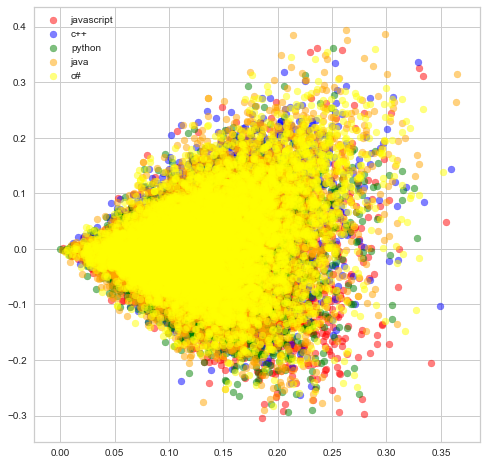

In [53]:
x = X_scaled[:, 0]
y = X_scaled[:, 1]
# color map
cdict = {'javascript': 'red', 'c++': 'blue',
         'python': 'green', 'java': 'orange', 'c#': 'yellow'}
fig, ax = plt.subplots(figsize = (8,8))
for g in label.unique():
    ix = np.where(label == g)
    ax.scatter(x[ix],y[ix],c=cdict[g],label = g, alpha = 0.5)
ax.legend()
plt.show()

### Observation:
  * Appears to have very little separation 
  * suggests clustering might be difficult for just 5 topics 
  
----

### Kmeans Clustering:  
 * n_cluster = 5
 * metric: silhouette_score (-1, 0, 1) 

In [61]:
# train kmeans model and fit on X 
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
pred_kmeans= kmeans.predict(X)
# use silhouette score, 1 is best, 0 suggests overlapping cluster 
silhouette_score(X,pred_kmeans)

0.003577455812403246

### observation:
 * As suggested by truncated SVD, clustesrs are overlapping with just 5 clusters
 
---

### LDA Models:
  * BOW
  * TFIDF

In [83]:
# remove words longer than length 2
# feature = feature.apply(
#     lambda x: [w for w in x if len(w) > 2])
# generate dictionary for the whole feature set and remove extremes but keep 50000
dictionary = gensim.corpora.Dictionary(feature)
dictionary.filter_extremes(no_below =1, no_above=0.05, keep_n=50000)
# create bag of words 
bow = [dictionary.doc2bow(doc) for doc in feature]
# create tfidf for bow 
tfidf = models.TfidfModel(bow)
corpus_tfidf = tfidf[bow]
# generate a model for bag of words with 5 topics 
lda_model = gensim.models.LdaMulticore(
    bow, num_topics=5, id2word=dictionary, passes=2, workers=4,random_state=42)
# generate a model for bag of tfidf with 5 topics 
lda_model_tfidf = gensim.models.LdaMulticore(
    corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4,random_state=42)

### top 5 words for each topic for bow

In [84]:
topic_top_word(lda_model)

,topic_0,topic_1,topic_2,topic_3,topic_4
0,byte,android,std,org,log
1,long,script,foo,key,source
2,thread,item,event,self,org
3,char,model,option,import,framework
4,size,date,template,foo,module


### top 5 words for each topic for tfidf

In [86]:
topic_top_word(lda_model_tfidf)

,topic_0,topic_1,topic_2,topic_3,topic_4
0,script,date,std,foo,thread
1,byte,item,foo,key,log
2,event,script,vector,print,arraylist
3,long,android,template,log,json
4,image,button,date,bar,private


### Observation:

* top 5 words for each topic is related less than 0.05 
  * suggest very little relevance for each topic for both bow and tfidf 
* clustering for 5 topics may be too few

* there are many permutations when combining language type and application types 
  * may require more topic numbers 


----
### Conclusions:

  * Supervised tag prediction works quite well with logistic regression 
  * topic clustering among the posts are quite challening as there are many hidden factors 

-----